# LSTM to predict the global active power

## Downloading Dataset and Extraction

In [1]:
from pathlib import Path

data_path = Path('data')
data_path.mkdir(exist_ok=True,parents=True) # create data directory if it doesn't exist

# download the data if it doesn't exist
if (data_path/"household_power_consumption.zip").exists():
    print("[Info] Data already downloaded, skipping download")
else:
    print("[Info] Downloading data...")
    !wget -O "data/household_power_consumption.zip" "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"

# extract the data if it doesn't exist
if (data_path/"household_power_consumption.txt").exists():
    print("[Info] Data already extracted, skipping extraction")
else:
    print("[Info] Extracting data...")
    !unzip -o "data/household_power_consumption.zip" -d "data"

[Info] Data already downloaded, skipping download
[Info] Data already extracted, skipping extraction


In [2]:
!cp "data/household_power_consumption.txt" "data/household_power_consumption.csv"

## Load the data using pandas

In [3]:
import pandas as pd
import numpy as np

In [4]:
dataset = pd.read_csv("data/household_power_consumption.csv", sep=";", low_memory=False, na_values=['?'], infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [5]:
dataset.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
column_names = dataset.columns
column_names

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [8]:
# replace nan values with median
for col in dataset.columns:
    dataset[col].fillna(dataset[col].median(), inplace=True)

In [9]:
X,y = dataset.iloc[:,:],dataset.iloc[:,1]
X.drop('Global_active_power',axis=1,inplace=True)

In [10]:
X[:5]

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,
2006-12-16 17:24:00,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,0.528,235.68,15.8,0.0,1.0,17.0


In [11]:
y[:5]

datetime
2006-12-16 17:24:00    0.418
2006-12-16 17:25:00    0.436
2006-12-16 17:26:00    0.498
2006-12-16 17:27:00    0.502
2006-12-16 17:28:00    0.528
Name: Global_reactive_power, dtype: float64

## Splitting the dataset into the Training set and Test set

In [12]:
# split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # making 80:20 split
print("shape of X_train: ", X_train.shape)
print("shape of y_train: ", y_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of y_test: ", y_test.shape)

shape of X_train:  (1660207, 6)
shape of y_train:  (1660207,)
shape of X_test:  (415052, 6)
shape of y_test:  (415052,)


In [13]:
X_train = X_train.values
y_train = y_train.values.reshape(-1,1)
X_test = X_test.values
y_test = y_test.values.reshape(-1,1)

## preprocessing with robust scaler

In [14]:
# preprocessing the data with robust scaler
from sklearn.preprocessing import RobustScaler
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)

In [15]:
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test)

In [16]:
X_train[:5]

array([[-0.69444444,  0.97135417, -0.36      ,  0.        ,  0.        ,
        -0.05882353],
       [-0.69444444, -0.10677083, -0.4       ,  0.        ,  0.        ,
        -0.05882353],
       [-0.01388889,  0.36197917, -0.32      ,  0.        ,  0.        ,
        -0.05882353],
       [-0.09722222,  0.7578125 , -0.24      ,  0.        ,  0.        ,
        -0.05882353],
       [-0.01388889,  0.84375   , -0.16      ,  0.        ,  1.        ,
         0.        ]])

## Importing requirements

In [17]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## device agnostic code

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Creating Dataset class for the torch dataset

### conveting scaled X and y to dataframes

In [19]:
column_names = list(column_names)
column_names

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

In [20]:
# convert the scaled data into dataframe
train_df = pd.DataFrame(X_train, columns=column_names[1:])
train_df['Global_active_power'] = y_train
train_df.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power
0,-0.694444,0.971354,-0.36,0.0,0.0,-0.058824,-0.694444
1,-0.694444,-0.106771,-0.40,0.0,0.0,-0.058824,-0.694444
2,-0.013889,0.361979,-0.32,0.0,0.0,-0.058824,-0.013889
3,-0.097222,0.757812,-0.24,0.0,0.0,-0.058824,-0.097222
4,-0.013889,0.843750,-0.16,0.0,1.0,0.000000,-0.013889


In [21]:
test_df = pd.DataFrame(X_test, columns=column_names[1:])
test_df['Global_active_power'] = y_test
test_df.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power
0,0.041667,0.257813,-0.28,0.0,0.0,0.000000,0.041667
1,1.750000,-0.986979,-0.04,0.0,2.0,-0.058824,1.750000
2,0.652778,-0.611979,0.12,0.0,1.0,-0.058824,0.652778
3,-0.375000,-0.096354,0.56,1.0,0.0,1.000000,-0.375000
4,0.708333,0.317708,-0.16,0.0,2.0,0.000000,0.708333


### Defining dataset Custom Class

In [22]:
import torch
from torch.utils.data import Dataset

class LSTMSequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        """
        Desc: 
            LSTMSequenceDataset class for creating sequences of data for LSTM

        Args:
            dataframe (pd.dataframe): pandas dataframe
            target (list): list of target
            features (list): list of features
            sequence_length (int, optional): number of sequence data to be concidered. Defaults to 5.
        Returns:
            Dataset: LSTMSequenceDataset object
        """
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.X = torch.tensor(dataframe[features].values).type(torch.float32)
        self.y = torch.tensor(dataframe[target].values).type(torch.float32)

    def __len__(self):
        """Returns the length of the dataset

        Returns:
            length (int): length of the dataset
        """
        return self.X.shape[0]

    def __getitem__(self, i): 
        """Creates a sequence of data for LSTM

        Args:
            i (index): index of the data

        Returns:
            X (torch.Tensor), y (torch.Tensor): sequence of data and target
        """
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i].item()

In [23]:
i = 42
sequence_length = 25
features = column_names[1:]
target = column_names[0]

print(f"fetures: {features}")
print(f"target: {target}")

# create train dataset
train_dataset = LSTMSequenceDataset(
    dataframe=train_df,
    target=target,
    features=features,
    sequence_length=sequence_length
)

# create test dataset
test_dataset = LSTMSequenceDataset(
    dataframe=test_df,
    target=target,
    features=features,
    sequence_length=sequence_length
)

# inspect the dataset by getting a sample
X_sample, y_sample = train_dataset[i]
print(f"X_sample: {X_sample}")
print(f"x_sample shape: {X_sample.shape}")
print(f"y_sample: {y_sample}")


fetures: ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
target: Global_active_power
X_sample: tensor([[ 1.4028e+00, -1.1380e+00,  3.1200e+00,  0.0000e+00,  2.1000e+01,
          9.4118e-01],
        [ 7.2222e-01,  7.9427e-01,  7.2000e-01,  0.0000e+00,  0.0000e+00,
          1.0588e+00],
        [ 1.8056e-01, -1.0365e+00, -3.2000e-01,  0.0000e+00,  0.0000e+00,
         -5.8824e-02],
        [ 6.9444e-02,  6.9271e-01, -2.4000e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 4.1667e-01,  1.7135e+00, -2.4000e-01,  0.0000e+00,  0.0000e+00,
         -5.8824e-02],
        [ 7.6389e-01,  1.5703e+00, -1.6000e-01,  0.0000e+00,  0.0000e+00,
         -5.8824e-02],
        [ 8.1944e-01, -1.6771e+00,  2.7200e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00],
        [ 8.0556e-01, -5.4688e-02,  1.1200e+00,  0.0000e+00,  1.7000e+01,
         -5.8824e-02],
        [ 1.5833e+00,  8.9844e-01, -4.0000e-02,  0.0000e+00,  2.00

In [24]:
print(f"length of train dataset: {len(train_dataset)}")
print(f"length of test dataset: {len(test_dataset)}")

length of train dataset: 1660207
length of test dataset: 415052


### Converting Dataset to dataloder

In [25]:
from torch.utils.data import DataLoader

BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

X_sample, y_sample = next(iter(train_dataloader))
# print(f"Train X_sample: {X_sample}")
print(f"Train x_sample shape: {X_sample.shape}")
print(f"length of train dataloader: {len(train_dataloader)}")
print(f"length of test dataloader: {len(test_dataloader)}")

Train x_sample shape: torch.Size([256, 25, 6])
length of train dataloader: 6486
length of test dataloader: 1622


## Defining Utils functions

### Plot loss curves of a model

In [26]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {
                "train_loss": [...],
                "test_loss": [...],
            }
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

### train step

In [27]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float) : training loss for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss = 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        y = y.type(torch.float32)
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # print(f"type of y_pred_logits: {y_pred_logits.dtype}, type of y: {y.dtype}")
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader)

### test step

In [28]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float): testing loss for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss = 0  # initlizing loss 

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader)

### training function

In [29]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["test_loss"].append(test_loss)

    # 5. return result dict
    return result_dict

## Defining the model

### model def.

In [30]:
from torch import nn

class LSTMModel0(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device=device)

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

### training the model

In [31]:
# init. model
model0 = LSTMModel0(num_features=6, hidden_units=256).to(device)
# init. epochs
NUM_EPOCHS = 10

# init. loss function, accuracy function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model0.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0111 | test_loss: 0.0035
Epoch: 2 | train_loss: 0.0036 | test_loss: 0.0056
Epoch: 3 | train_loss: 0.0030 | test_loss: 0.0037
Epoch: 4 | train_loss: 0.0026 | test_loss: 0.0025
Epoch: 5 | train_loss: 0.0023 | test_loss: 0.0020
Epoch: 6 | train_loss: 0.0021 | test_loss: 0.0025
Epoch: 7 | train_loss: 0.0020 | test_loss: 0.0028
Epoch: 8 | train_loss: 0.0019 | test_loss: 0.0018
Epoch: 9 | train_loss: 0.0017 | test_loss: 0.0025
Epoch: 10 | train_loss: 0.0016 | test_loss: 0.0016
total training time: 435.063 sec.



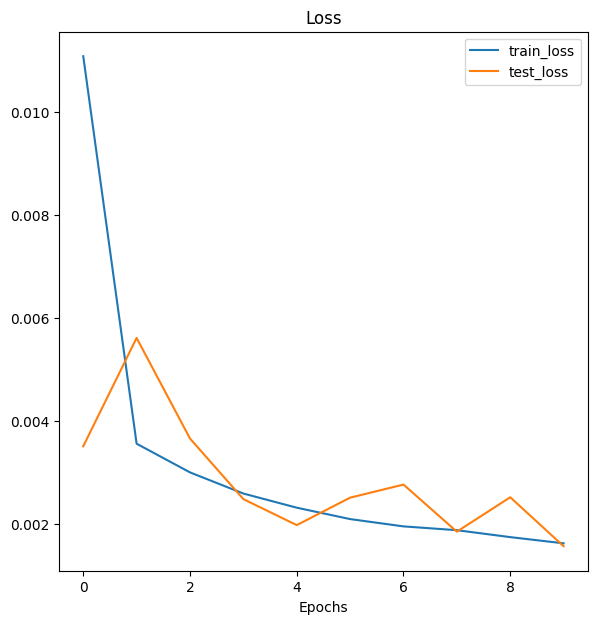

In [32]:
from timeit import default_timer as timer

start_time = timer()
# train model
model0_results = train(
    model=model0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model0_results)
print()

# Make split to 70:30 ratio

## Splitting the dataset into the Training set and Test set

In [33]:
# split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # making 70:30 split
print("shape of X_train: ", X_train.shape)
print("shape of y_train: ", y_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of y_test: ", y_test.shape)

shape of X_train:  (1452681, 6)
shape of y_train:  (1452681,)
shape of X_test:  (622578, 6)
shape of y_test:  (622578,)


In [34]:
X_train = X_train.values
y_train = y_train.values.reshape(-1,1)
X_test = X_test.values
y_test = y_test.values.reshape(-1,1)

## preprocessing with robust scaler

In [35]:
# preprocessing the data with robust scaler
from sklearn.preprocessing import RobustScaler
scaler_x = RobustScaler()
scaler_y = RobustScaler()
X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)

In [36]:
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test)

In [37]:
X_train[:5]

array([[-2.53521127e-01, -1.59375000e+00,  2.40000000e-01,
         0.00000000e+00,  0.00000000e+00, -5.88235294e-02],
       [ 2.52112676e+00, -1.17968750e+00,  2.84000000e+00,
         3.90000000e+01,  3.00000000e+00, -5.88235294e-02],
       [-1.69014085e-01,  1.17968750e+00, -2.00000000e-01,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-7.04225352e-01,  5.52083333e-01,  1.60000000e-01,
         0.00000000e+00,  0.00000000e+00, -5.88235294e-02],
       [-2.11267606e-01,  2.60416667e-02, -1.20000000e-01,
         0.00000000e+00,  0.00000000e+00, -5.88235294e-02]])

## Creating Dataset class for the torch dataset

### conveting scaled X and y to dataframes

In [38]:
column_names = list(column_names)
column_names

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

In [39]:
# convert the scaled data into dataframe
train_df = pd.DataFrame(X_train, columns=column_names[1:])
train_df['Global_active_power'] = y_train
train_df.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power
0,-0.253521,-1.593750,0.24,0.0,0.0,-0.058824,-0.253521
1,2.521127,-1.179687,2.84,39.0,3.0,-0.058824,2.521127
2,-0.169014,1.179687,-0.20,0.0,1.0,0.000000,-0.169014
3,-0.704225,0.552083,0.16,0.0,0.0,-0.058824,-0.704225
4,-0.211268,0.026042,-0.12,0.0,0.0,-0.058824,-0.211268


In [40]:
test_df = pd.DataFrame(X_test, columns=column_names[1:])
test_df['Global_active_power'] = y_test
test_df.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power
0,0.042254,0.257813,-0.28,0.0,0.0,0.000000,0.042254
1,1.774648,-0.986979,-0.04,0.0,2.0,-0.058824,1.774648
2,0.661972,-0.611979,0.12,0.0,1.0,-0.058824,0.661972
3,-0.380282,-0.096354,0.56,1.0,0.0,1.000000,-0.380282
4,0.718310,0.317708,-0.16,0.0,2.0,0.000000,0.718310


In [41]:
i = 42
sequence_length = 25
features = column_names[1:]
target = column_names[0]

print(f"fetures: {features}")
print(f"target: {target}")

# create train dataset
train_dataset = LSTMSequenceDataset(
    dataframe=train_df,
    target=target,
    features=features,
    sequence_length=sequence_length
)

# create test dataset
test_dataset = LSTMSequenceDataset(
    dataframe=test_df,
    target=target,
    features=features,
    sequence_length=sequence_length
)

# inspect the dataset by getting a sample
X_sample, y_sample = train_dataset[i]
print(f"X_sample: {X_sample}")
print(f"x_sample shape: {X_sample.shape}")
print(f"y_sample: {y_sample}")


fetures: ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
target: Global_active_power
X_sample: tensor([[ 1.7042e+00,  6.6406e-01, -4.0000e-02,  0.0000e+00,  2.0000e+00,
         -5.8824e-02],
        [ 1.7746e+00,  8.4115e-01, -4.0000e-02,  0.0000e+00,  2.0000e+00,
         -5.8824e-02],
        [ 2.1127e-01,  4.4271e-01, -3.2000e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 8.0282e-01,  1.1615e+00, -2.0000e-01,  0.0000e+00,  0.0000e+00,
         -5.8824e-02],
        [-7.0423e-01,  5.1823e-01,  1.6000e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 9.4366e-01,  1.6927e-01,  1.1600e+00,  0.0000e+00,  0.0000e+00,
          1.0588e+00],
        [ 8.4507e-02,  9.2188e-01,  5.6000e-01,  0.0000e+00,  0.0000e+00,
         -5.8824e-02],
        [ 5.6338e-01,  3.8542e-01, -1.2000e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1268e+00, -1.0703e+00,  8.8000e-01,  0.0000e+00,  0.00

In [42]:
print(f"length of train dataset: {len(train_dataset)}")
print(f"length of test dataset: {len(test_dataset)}")

length of train dataset: 1452681
length of test dataset: 622578


### Converting Dataset to dataloder

In [43]:
from torch.utils.data import DataLoader

BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

X_sample, y_sample = next(iter(train_dataloader))
# print(f"Train X_sample: {X_sample}")
print(f"Train x_sample shape: {X_sample.shape}")
print(f"length of train dataloader: {len(train_dataloader)}")
print(f"length of test dataloader: {len(test_dataloader)}")

Train x_sample shape: torch.Size([256, 25, 6])
length of train dataloader: 5675
length of test dataloader: 2432


## Defining the model

### training the model

In [44]:
# init. model
model1 = LSTMModel0(num_features=6, hidden_units=256).to(device)
# init. epochs
NUM_EPOCHS = 10

# init. loss function, accuracy function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0126 | test_loss: 0.0027
Epoch: 2 | train_loss: 0.0037 | test_loss: 0.0022
Epoch: 3 | train_loss: 0.0032 | test_loss: 0.0031
Epoch: 4 | train_loss: 0.0028 | test_loss: 0.0023
Epoch: 5 | train_loss: 0.0026 | test_loss: 0.0016
Epoch: 6 | train_loss: 0.0023 | test_loss: 0.0020
Epoch: 7 | train_loss: 0.0021 | test_loss: 0.0016
Epoch: 8 | train_loss: 0.0020 | test_loss: 0.0023
Epoch: 9 | train_loss: 0.0019 | test_loss: 0.0019
Epoch: 10 | train_loss: 0.0018 | test_loss: 0.0025
total training time: 409.543 sec.



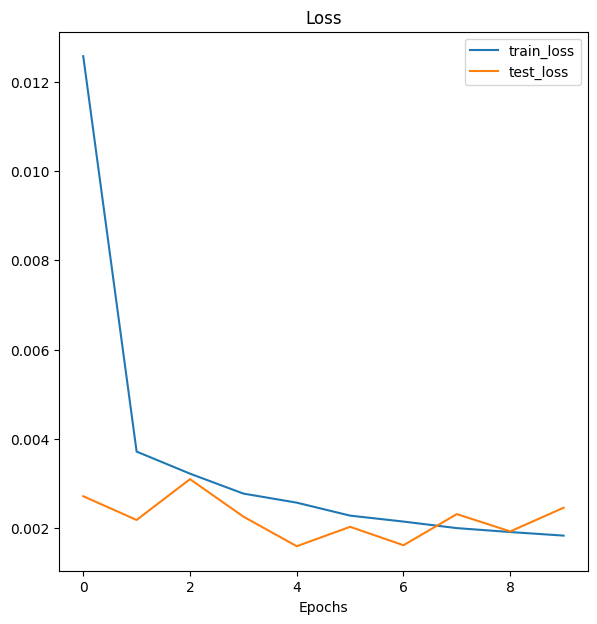

In [45]:
from timeit import default_timer as timer

start_time = timer()
# train model
model1_results = train(
    model=model1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model1_results)
print()